## load data

In [2]:
import pandas as pd

emotion_data = pd.read_csv("./data/emotion.csv" , sep = "," , names = ["tweet_id" , "emotion"] , skiprows=[0])
identification_data = pd.read_csv("./data/data_identification.csv" , sep = "," , names = ["tweet_id" , "identification"], skiprows=[0])
tweets_data = pd.read_json("./data/tweets_DM.json" , lines = True)

In [4]:
import json
from pandas.io.json import json_normalize

data_df = json_normalize(tweets_data._source)
data_df = data_df.reindex(columns=['tweet.tweet_id','tweet.hashtags','tweet.text'])
data_df = data_df.rename(columns={'tweet.tweet_id':'tweet_id' , 'tweet.hashtags':'hashtags' , 'tweet.text':'text' })

C:\Users\jybrl\AppData\Local\Temp/ipykernel_2760/2148091692.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data_df = json_normalize(tweets_data._source)


In [5]:
data_merge_emotion = pd.merge(data_df, emotion_data , on=['tweet_id'], how="outer")
data_all_info = pd.merge(data_merge_emotion, identification_data , on=['tweet_id'], how="outer")


In [6]:
grouped = data_all_info.groupby(data_all_info.identification) 
train_df = grouped.get_group("train") 
test_df = grouped.get_group("test") 

In [7]:
train_df[:10]

,tweet_id,hashtags,text,emotion,identification
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",anticipation,train
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",sadness,train
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,train
5,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,joy,train
6,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,anticipation,train
7,0x368e95,[],Love knows no gender. 😢😭 <LH>,joy,train
8,0x249c0c,[LeagueCup],@DStvNgCare @DStvNg More highlights are being ...,sadness,train
10,0x359db9,"[SSM, gender, diversity]",The #SSM debate; <LH> (a manufactured fantasy ...,anticipation,train
11,0x23b037,[],I love suffering 🙃🙃 I love when valium does no...,joy,train
12,0x1fde89,[Pissed],Can someone tell my why my feeds scroll back t...,anger,train


save to pickle file

In [7]:
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

## Preprocessing

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import CSVLogger
import nltk
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
import re
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
import re
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jybrl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


load a pickle file

In [9]:
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

remove punctuation

In [10]:
import string

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

train_df['text_without_punct'] = train_df['text'].apply(lambda x : remove_punctuation(x))
test_df['text_without_punct'] = test_df['text'].apply(lambda x : remove_punctuation(x))

deal with emoji

In [11]:
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
filt = '[!"#$%&()*,-./:;<=>?@[\]^_`{|}~ ]'

train_df['split'] = train_df['text'] .apply(lambda x: x.replace("<LH>",""))
train_df['split'] = train_df['split'].apply(lambda x: re.sub(filt, ' ', x.lower()))
train_df['split'] = train_df['split'].apply(lambda x: re.sub(r'\d+', " ", x))
train_df['split'] = train_df['split'].apply(lambda x: re.sub('<[^<]+?>', " ", x))
train_df['split'] = train_df['split'].apply(lambda x: x.split(" "))

test_df['split'] = test_df['text'] .apply(lambda x: x.replace("<LH>",""))
test_df['split'] = test_df['split'].apply(lambda x: re.sub(filt, ' ', x.lower()))
test_df['split'] = test_df['split'].apply(lambda x: re.sub(r'\d+', " ", x))
test_df['split'] = test_df['split'].apply(lambda x: re.sub('<[^<]+?>', " ", x))
test_df['split'] = test_df['split'].apply(lambda x: x.split(" "))

deal with stopwords

In [12]:
stop_words = set(stopwords.words('english'))

train_df['no_stopwords'] = train_df['split'].apply(lambda x: [item for item in x if item not in stop_words])
train_df['no_stopwords'] = train_df['no_stopwords'].apply(lambda x: [item for item in x if len(item) > 1])
test_df['no_stopwords'] = test_df['split'].apply(lambda x: [item for item in x if item not in stop_words])
test_df['no_stopwords'] = test_df['no_stopwords'].apply(lambda x: [item for item in x if len(item) > 1])

stemming and lemmatization

In [13]:
porter = nltk.stem.PorterStemmer()
lemmatizer = WordNetLemmatizer() 
train_df['stemmed'] = train_df['no_stopwords'].apply(lambda x: [porter.stem(y) for y in x])
test_df['stemmed'] = test_df['no_stopwords'].apply(lambda x: [porter.stem(y) for y in x])
train_df['lemmatization'] = train_df['no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
test_df['lemmatization'] = test_df['no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
train_df['lem_ste'] = train_df['lemmatization'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
test_df['lem_ste'] = test_df['lemmatization'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [14]:
train_df['clean'] = train_df['lem_ste'].apply(lambda x: [item for item in x if not item.isnumeric() ])
train_df['cleaned'] = train_df['clean'].apply(' '.join)

test_df['clean'] = test_df['lem_ste'].apply(lambda x: [item for item in x if not item.isnumeric() ])
test_df['cleaned'] = test_df['clean'].apply(' '.join)

In [52]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=15000, 
                             use_idf=True,  
                             tokenizer=tweet_tokenizer.tokenize,
                             stop_words=stopwords.words('english').append('lh')
                             )

tfidf_vectorizer.fit(train_df['cleaned'])

C:\Users\jybrl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_features=15000,
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002669DD170A0>>)

merge emotion and cleaned text

In [53]:
train_labeled = pd.merge(train_df,emotion_data)[['cleaned','emotion']]


MemoryError: Unable to allocate 2.71 TiB for an array with shape (372467773901,) and data type int64

save cleaned data and labeled data

In [ ]:
train_df.to_pickle("train_cleaned_df.pkl") 
test_df.to_pickle("test_cleaned_df.pkl")
train_labeled.to_pickle("train_labeled_df.pkl")

In [50]:
train_labeled.to_csv("train_labeled_df.csv")
test_df.to_csv("test_cleaned_df.csv")

NameError: name 'train_labeled' is not defined

## prepare label

load data

In [20]:
import pandas as pd

df = pd.read_pickle("train_labeled_df.pkl")
df = df.sample(frac=1)

val_df = df[:150000]
train_df = df[150000:]

In [21]:
classes = set(train_df['emotion'])

In [22]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [23]:
import numpy as np

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

train_labels = names_to_ids(train_df['emotion'])

## tokenizing and padding

tokenization

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(train_df['cleaned'])

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=80, padding='post')
    return padded_sequences

In [37]:
padded_train_sequences = get_sequences(tokenizer, train_df['cleaned'])

## create model

In [38]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(15000, 32, input_length=80),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, kernel_initializer='normal', activation='sigmoid'),
    tf.keras.layers.Dense(128, kernel_initializer='normal', activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 32)            480000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 80, 256)          164864    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 8)                

## train model

In [39]:
val_labels = names_to_ids(val_df['emotion'])
val_tweets = val_df['cleaned']
val_sequences = get_sequences(tokenizer, val_tweets)

In [40]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/8
40799/40799 [==============================] - 5350s 131ms/step - loss: 1.3296 - accuracy: 0.5224 - val_loss: 1.2719 - val_accuracy: 0.5442
Epoch 2/8
40799/40799 [==============================] - 5317s 130ms/step - loss: 1.2480 - accuracy: 0.5517 - val_loss: 1.2520 - val_accuracy: 0.5501
Epoch 3/8
40799/40799 [==============================] - 5290s 130ms/step - loss: 1.2204 - accuracy: 0.5605 - val_loss: 1.2355 - val_accuracy: 0.5556
Epoch 4/8
40799/40799 [==============================] - 5150s 126ms/step - loss: 1.1987 - accuracy: 0.5685 - val_loss: 1.2300 - val_accuracy: 0.5579
Epoch 5/8
40799/40799 [==============================] - 5287s 130ms/step - loss: 1.1792 - accuracy: 0.5753 - val_loss: 1.2285 - val_accuracy: 0.5587
Epoch 6/8
40799/40799 [==============================] - 5159s 126ms/step - loss: 1.1604 - accuracy: 0.5817 - val_loss: 1.2350 - val_accuracy: 0.5582
Epoch 7/8
40799/40799 [==============================] - 5155s 126ms/step - loss: 1.1421 - accuracy:

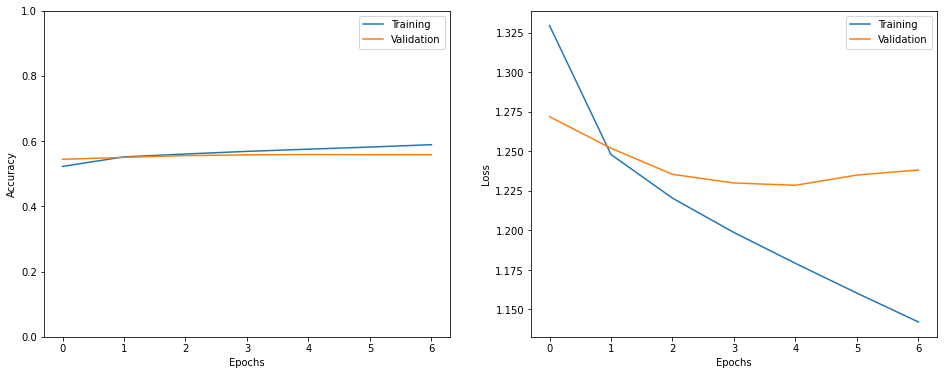

In [41]:
import matplotlib.pyplot as plt

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

## test

In [1]:
test_df = pd.read_pickle("test_cleaned_df.pkl")
test_tweets = test_df['cleaned']
test_sequences = get_sequences(tokenizer, test_tweets)

preds = model.predict(test_sequences)
p = np.argmax(preds,axis=1)

NameError: name 'pd' is not defined

In [ ]:
result_df = pd.DataFrame()

result_df['id'] = test_df['tweet_id']

emotion = []

for i in p:
    emotion.append(index_to_classes.get(i))

result_df['emotion'] = emotion

result_df.to_csv('result5.csv')